In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Exploratory Data Analysis

In [2]:
# set the stopword 
stopword = set(stopwords.words('english'))
stopwords

<WordListCorpusReader in 'C:\\Users\\vrush\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [3]:
data = pd.read_csv(r'amazon_alexa.tsv', delimiter='\t')
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [4]:
# shape of the data 
print("Shape of the Data :",data.shape)

Shape of the Data : (3150, 5)


In [5]:
# check null va;ue 
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
data.loc[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
data.dropna(inplace = True)

In [8]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [9]:
# create a new column 'length' that will contain the length of the string in verified_reviews column
data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


# Randomly checking for 10th record
print(f"'verified_reviews' column value : {data.iloc[10]['verified_reviews']}")
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")

#### Check Data Types of the columns 

In [10]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- rating, feedback and length are the integer values
- date , variation, verified_reviews

### Analyzing `rating` column

#### This column refers to the rating of the variation given by the user 

In [11]:
# Distinct values of 'rating' and its count 
print(f"Rating value count : \n{data['rating'].value_counts()}")

Rating value count : 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


C:\Users\vrush\AppData\Local\Temp\ipykernel_9560\2948686699.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data['rating'].value_counts(), palette='rainbow', edgecolor='black')


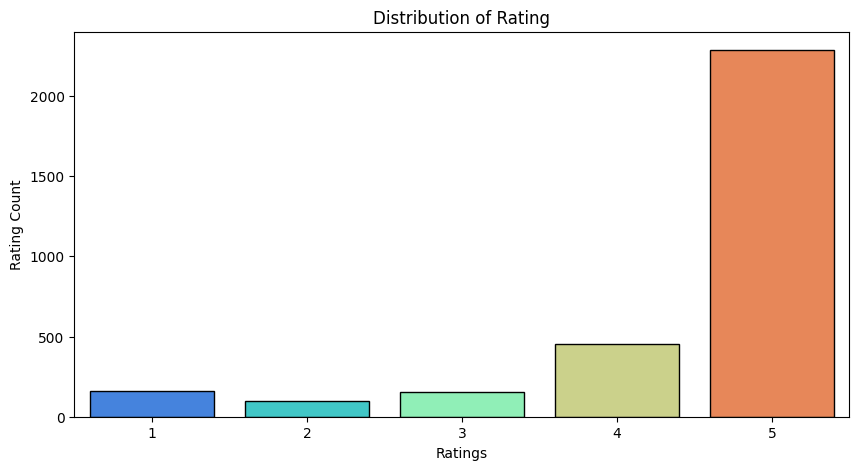

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data['rating'].value_counts(), palette='rainbow', edgecolor='black')
plt.title("Distribution of Rating")
plt.xlabel("Ratings")
plt.ylabel("Rating Count")
plt.show()

In [13]:
# Percentage distribution of Rating 
rating_pct = data['rating'].value_counts(normalize=True) * 100
rating_pct

rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: proportion, dtype: float64

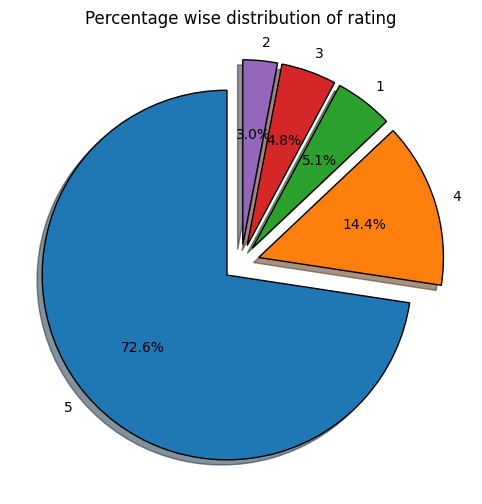

In [14]:
plt.figure(figsize = (10,6))
colors = ['#99ff99','#ff9999','#4CAF50','#FF5722','#66b3ff']
explode=(0.1,0.1,0.1,0.1,0.1)
wp = {'linewidth':1, "edgecolor":'black'}

plt.pie(rating_pct ,labels = rating_pct.index, 
        autopct = '%1.1f%%', startangle = 90,
       explode=explode, shadow = True, wedgeprops=wp
       )


plt.title("Percentage wise distribution of rating")
plt.show()
plt.show()

#### Analyze feedback column

In [15]:
# Check the distinct values and its count 
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

#### We have only two feedback values 
-    #### feedback value = 0 (Negative Feedback)
-    #### feedback value = 1 (Positive feedback)

#### Analyzed feed value 0

In [16]:
# Extracting the verified_reviews value for one record with feedback 0 
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
review_0

'Sound is terrible if u want good music too get a bose'

C:\Users\vrush\AppData\Local\Temp\ipykernel_9560\3184643410.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data['feedback'].value_counts(), palette='rainbow', edgecolor = 'black')


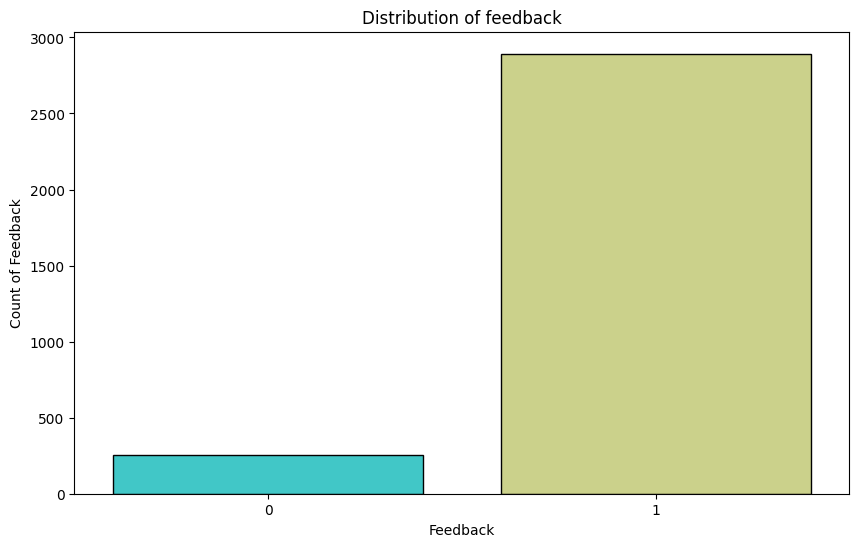

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data['feedback'].value_counts(), palette='rainbow', edgecolor = 'black')
plt.title('Distribution of feedback')
plt.xlabel("Feedback")
plt.ylabel("Count of Feedback")
plt.show()

In [18]:
data['feedback'].value_counts(normalize = True) * 100

feedback
1    91.870435
0     8.129565
Name: proportion, dtype: float64

#### Feedback Distribution 
-   #### 91.87% review are Positive
-   #### 8.13% review are Negative 

In [19]:
feedback_pct = data['feedback'].value_counts(normalize = True)
feedback_pct

feedback
1    0.918704
0    0.081296
Name: proportion, dtype: float64

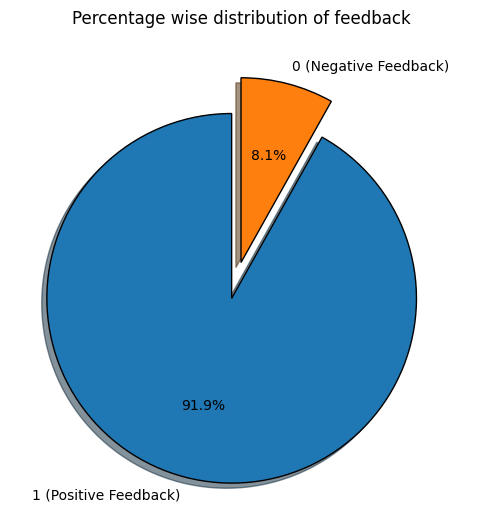

In [20]:
plt.figure(figsize = (10,6))

feedback_pct.index = feedback_pct.index.map({0: "0 (Negative Feedback)", 
                                             1: "1 (Positive Feedback)"})
colors = ['#99ff99','#ff9999']
explode=(0.2,0)
wp = {'linewidth':1, "edgecolor":'black'}

plt.pie(feedback_pct ,labels = feedback_pct.index, 
        autopct = '%1.1f%%', startangle = 90,
       explode=explode, shadow = True, wedgeprops=wp
       )
plt.title("Percentage wise distribution of feedback")
plt.show()

#### Lets see the rating value for different value of feedback 

In [21]:
# For feedback 0 rating values 
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [22]:
# feedback 1 rating values are 
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

#### We can see that if `rating` is `1` or `2` then the `feedback` is `0 (Negative Feedback)` and if `rating` values is `3`, `4` and `5` then `feedback` is `1 (Positive Feedback)`

#### Analyzing `variation` columns 
-  #### This columns refers to the `variation` or `type of Amazon Alexa product` Example - `Black Dot`, `Charcoal Fabric`

In [23]:
# see the distinct values in variation 
data['variation'].unique()

array(['Charcoal Fabric ', 'Walnut Finish ', 'Heather Gray Fabric ',
       'Sandstone Fabric ', 'Oak Finish ', 'Black', 'White',
       'Black  Spot', 'White  Spot', 'Black  Show', 'White  Show',
       'Black  Plus', 'White  Plus', 'Configuration: Fire TV Stick',
       'Black  Dot', 'White  Dot'], dtype=object)

In [24]:
# COunt of the distinct values in variation 
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

C:\Users\vrush\AppData\Local\Temp\ipykernel_9560\2911185313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data['variation'].value_counts(), palette='rainbow', edgecolor='black')


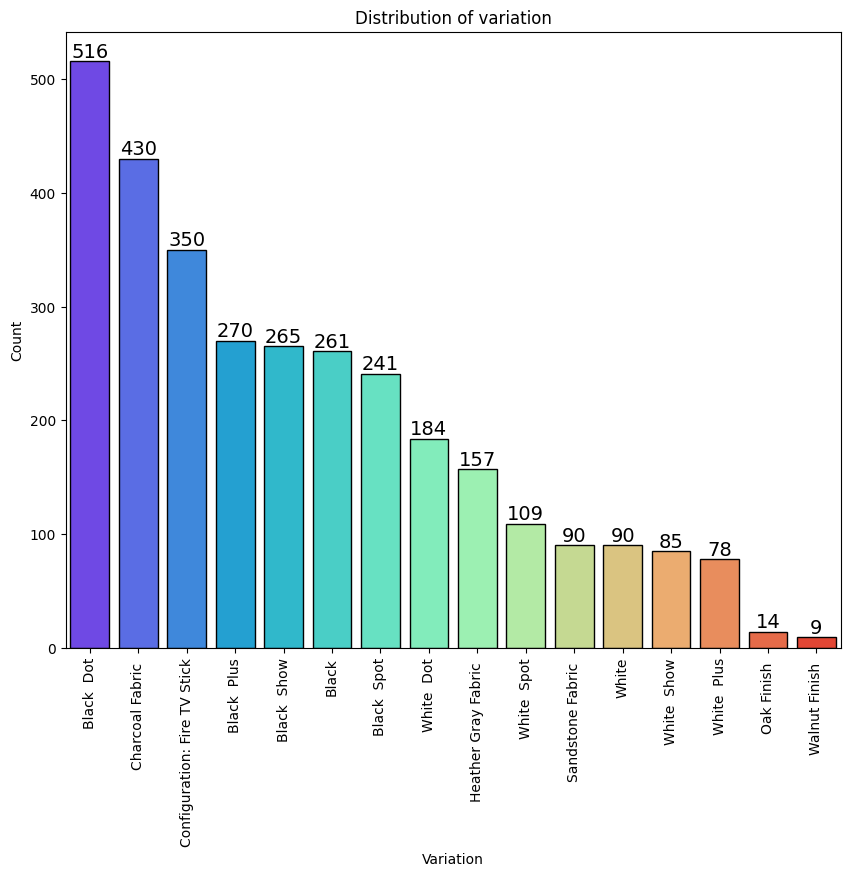

In [25]:
plt.figure(figsize = (10,8))
ax = sns.barplot(data['variation'].value_counts(), palette='rainbow', edgecolor='black')
plt.title("Distribution of variation")
plt.xlabel("Variation")
plt.ylabel("Count")

for label in ax.containers:
    ax.bar_label(label, fontsize = 14)

plt.xticks(rotation = 90)
plt.show()

In [26]:
# see the percentage distribution of the variation
round(data['variation'].value_counts(normalize = True) * 100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: proportion, dtype: float64

### Mean rating by variation

In [27]:
mean_rating_variation = round(data.groupby('variation')['rating'].mean(),2)
mean_rating_variation

variation
Black                           4.23
Black  Dot                      4.45
Black  Plus                     4.37
Black  Show                     4.49
Black  Spot                     4.31
Charcoal Fabric                 4.73
Configuration: Fire TV Stick    4.59
Heather Gray Fabric             4.69
Oak Finish                      4.86
Sandstone Fabric                4.36
Walnut Finish                   4.89
White                           4.17
White  Dot                      4.42
White  Plus                     4.36
White  Show                     4.28
White  Spot                     4.31
Name: rating, dtype: float64

C:\Users\vrush\AppData\Local\Temp\ipykernel_9560\2234963156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(mean_rating_variation.sort_values(), palette='rainbow', edgecolor='black')


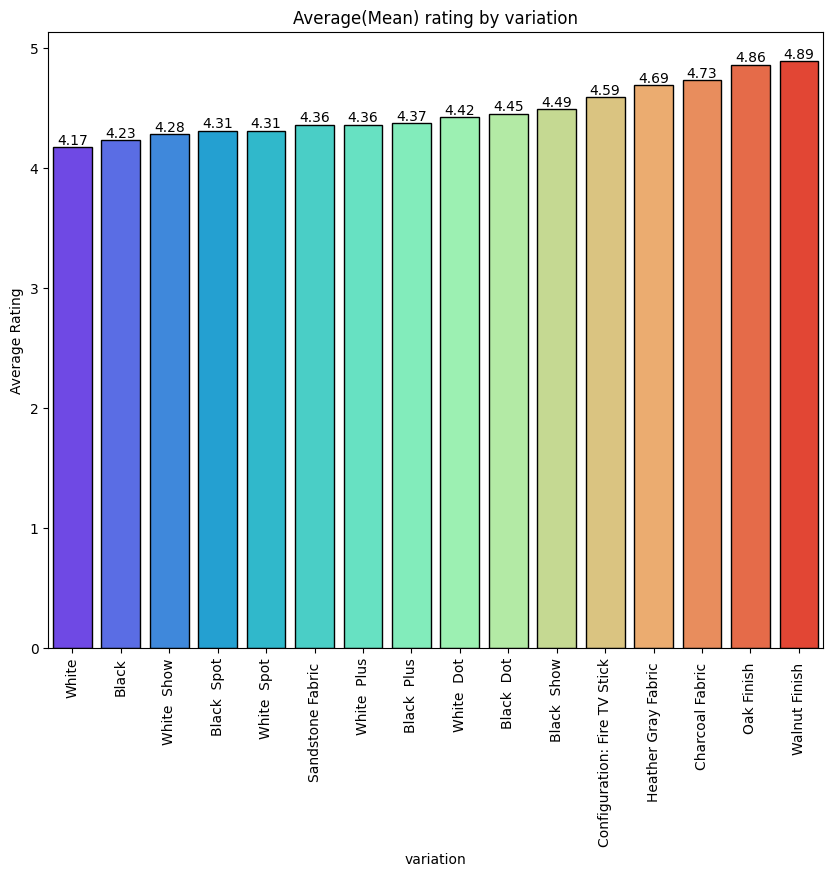

In [28]:
plt.figure(figsize=(10,8))
ax = sns.barplot(mean_rating_variation.sort_values(), palette='rainbow', edgecolor='black')
plt.title("Average(Mean) rating by variation")
plt.xlabel("variation")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)

for label in ax.containers:
    ax.bar_label(label)
plt.show()

#### Analyzing `verified_reviews` column

In [29]:
print("Number of Unique Verified Reviews :",len(data.verified_reviews.unique()))

Number of Unique Verified Reviews : 2300


In [30]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

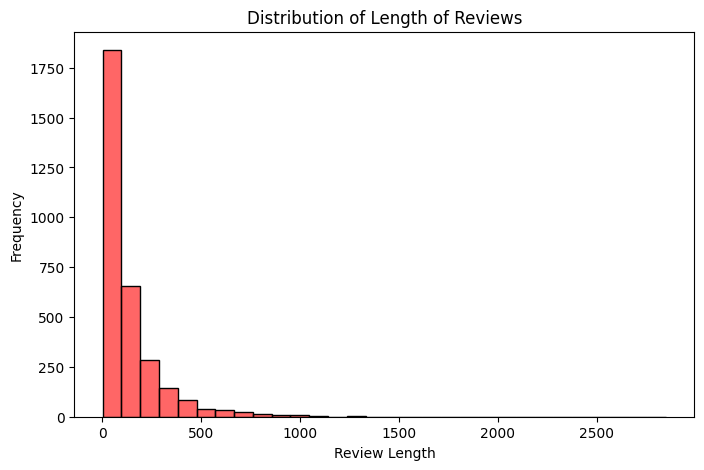

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(data['length'], color='red', bins=30, kde=False, alpha=0.6)
plt.title('Distribution of Length of Reviews')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

#### Analysis of length when feedback is 0(Negative)

In [32]:
feedback_0 = data[data['feedback'] == 0]['length']
feedback_0

46      163
111      53
141      18
162      87
176      20
       ... 
3047    120
3048     37
3067    240
3091     17
3096    210
Name: length, Length: 256, dtype: int64

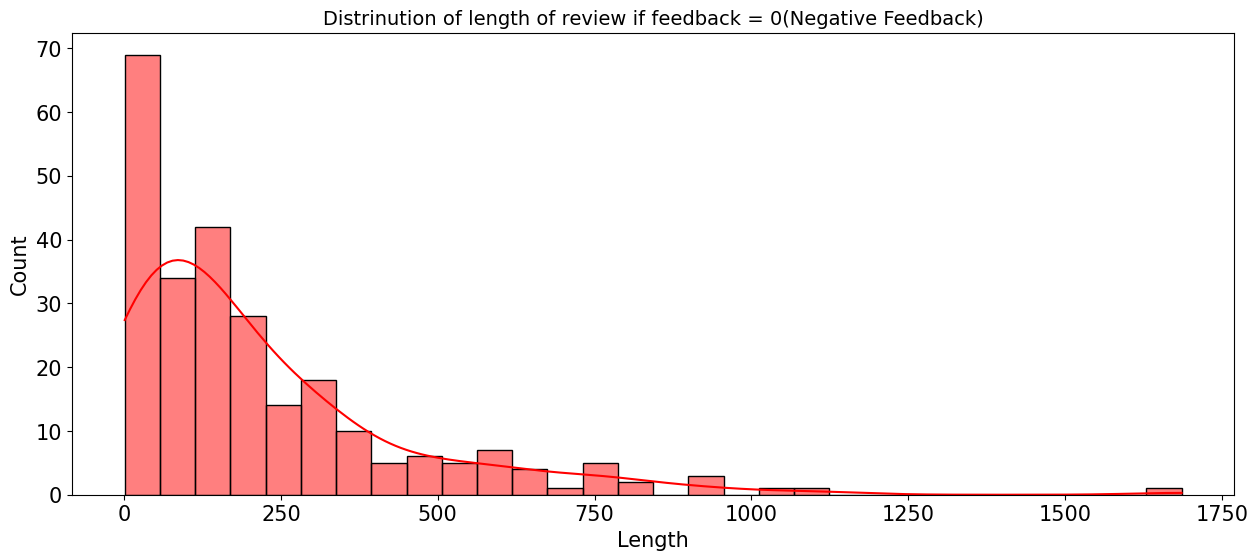

In [33]:
plt.figure(figsize =(15,6))
sns.histplot(feedback_0, color = 'red', bins = 30, kde=True)
plt.title('Distrinution of length of review if feedback = 0(Negative Feedback)', fontsize = 14)
plt.xlabel("Length", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

#### Length of review when feed back is 1 (Positive Feedback)

In [34]:
feedback_1 = data[data['feedback']== 1]['length']
feedback_1

0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: length, Length: 2893, dtype: int64

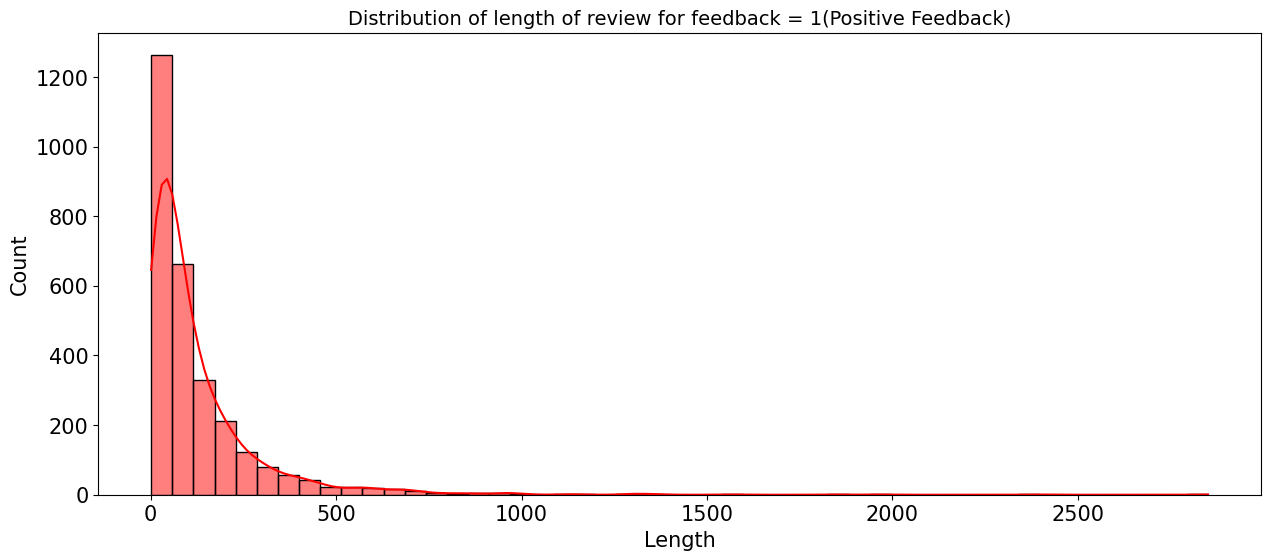

In [35]:
plt.figure(figsize =(15,6))
sns.histplot(feedback_1, color = 'red', bins = 50, kde = True)
plt.title("Distribution of length of review for feedback = 1(Positive Feedback)",  fontsize = 14)
plt.xlabel("Length", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [36]:
avg_rating_by_review_length = data.groupby('length')['rating'].mean()
avg_rating_by_review_length

length
1       3.716049
2       5.000000
3       4.000000
4       4.785714
5       4.823529
          ...   
1686    2.000000
1833    3.000000
1954    3.000000
2393    5.000000
2851    5.000000
Name: rating, Length: 490, dtype: float64

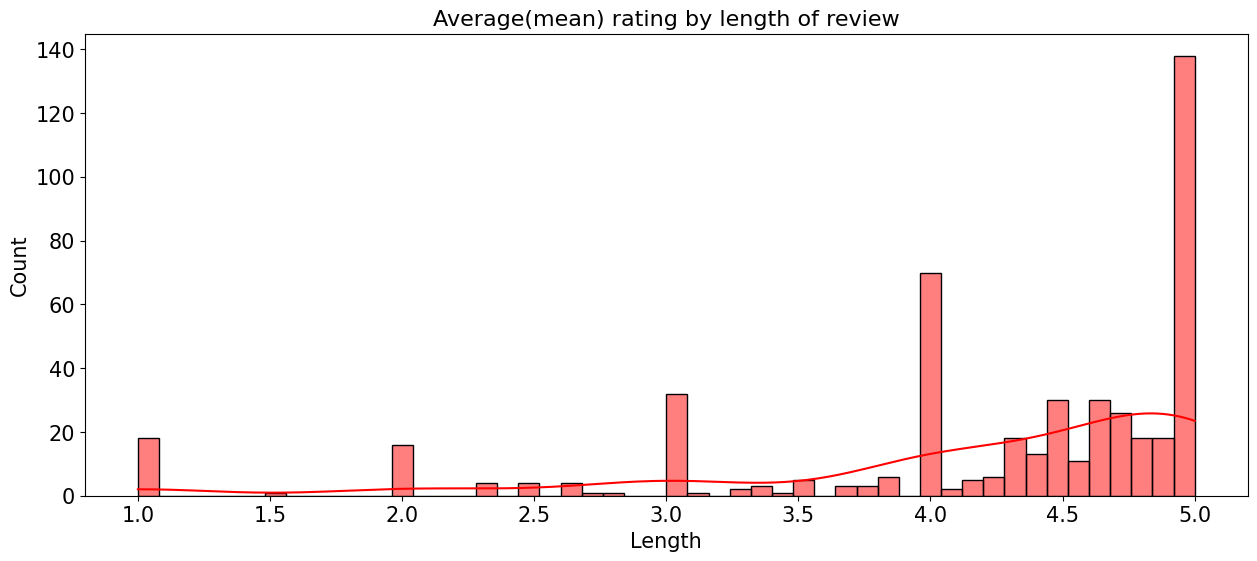

In [37]:
plt.figure(figsize =(15,6))
sns.histplot(avg_rating_by_review_length, color = 'red', bins = 50, kde = True)
plt.title("Average(mean) rating by length of review",  fontsize = 16)
plt.xlabel("Length", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

## Preprocessing and Modelling

To build the corpus from the `verified_reviews` we perform the following
- 1.Replace any no alphabhate character with space
- 2.Convert to lower case and split into words
- 3.Iterate over the individual words and if it os not a stopword then add the stemmed form of the word to the corpus

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []
stemmer = PorterStemmer()
stopword = set(stopwords.words('english'))

for i in range(data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in stopword]
    review = ' '.join(review)
    corpus.append(review)

In [39]:
corpus[1]

'love'

#### Use `TF-IDF (Term Frequesncy - Inverse Document Frequency)`

In [40]:
tfidf = TfidfVectorizer(max_features=2500)
X = tfidf.fit_transform(corpus).toarray()
y = data['feedback'].values

In [41]:
X.shape

(3149, 2500)

In [42]:
y.shape

(3149,)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=15, stratify=y
)

In [44]:
print(f"X train shape : {X_train.shape}")
print(f"X test shape : {X_test.shape}")
print(f"y train shape : {y_train.shape}")
print(f"y test shape : {y_test.shape}")

X train shape : (2204, 2500)
X test shape : (945, 2500)
y train shape : (2204,)
y test shape : (945,)


#### Apply SMOTE to balance the data 

#### We know that our feedback column is highly imbalance thats why we used this 

In [45]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [46]:
print("Shape of the Data After Sampling")
print(f"X train shape : {X_train_res.shape}")
print(f"X test shape : {X_test.shape}")
print(f"y train shape : {y_train_res.shape}")
print(f"y test shape : {y_test.shape}")

Shape of the Data After Sampling
X train shape : (4050, 2500)
X test shape : (945, 2500)
y train shape : (4050,)
y test shape : (945,)


#### Train data with different models

In [47]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

In [48]:
from sklearn.metrics import classification_report 
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    
    # Store class 0 performance
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "Recall_0": report['0']['recall'],
        "F1_0": report['0']['f1-score'],
        "Overall Accuracy": report['accuracy']
    }


🔹 Training Decision Tree...

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0     0.3672    0.6104    0.4585        77
           1     0.9633    0.9067    0.9341       868

    accuracy                         0.8825       945
   macro avg     0.6652    0.7585    0.6963       945
weighted avg     0.9147    0.8825    0.8954       945


🔹 Training Random Forest...

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0     0.4579    0.6364    0.5326        77
           1     0.9666    0.9332    0.9496       868

    accuracy                         0.9090       945
   macro avg     0.7123    0.7848    0.7411       945
weighted avg     0.9251    0.9090    0.9156       945


🔹 Training XGBoost...


c:\Users\vrush\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report for XGBoost:

              precision    recall  f1-score   support

           0     0.3378    0.6494    0.4444        77
           1     0.9661    0.8871    0.9249       868

    accuracy                         0.8677       945
   macro avg     0.6520    0.7682    0.6847       945
weighted avg     0.9149    0.8677    0.8858       945



#### We can see that our Random Forest model perform well than XgBoost and Decision Tree. So i choose an Random Forest Model and perform some hyperparameter tunning

### Apply RandonSearchCV

In [49]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Define an Model
rf = RandomForestClassifier(random_state=42)

# Apply Random Search CV
# Randomized Search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    cv=3,
    scoring='f1_macro',  # macro avg ensures class 0 is weighted equally
    n_jobs=-1,
    random_state=42
)


In [50]:
# fit the model with training data with somet applied 
random_search.fit(X_train_res, y_train_res)

# Find the Best parameter and Best score 
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': None}
Best Score: 0.9718340214166935


In [75]:
best_rf = random_search.best_estimator_

In [76]:
best_rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_res, y_train_res)

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
y_pred = best_rf.predict(X_test)
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [80]:
report = classification_report(y_test, y_pred, digits=4)
cm = confusion_matrix(y_test, y_pred)

print("Classification Report :\n",report)
print("Confusion Matrix :\n",cm)


Classification Report :
               precision    recall  f1-score   support

           0     0.5135    0.4935    0.5033        77
           1     0.9552    0.9585    0.9569       868

    accuracy                         0.9206       945
   macro avg     0.7344    0.7260    0.7301       945
weighted avg     0.9192    0.9206    0.9199       945

Confusion Matrix :
 [[ 38  39]
 [ 36 832]]


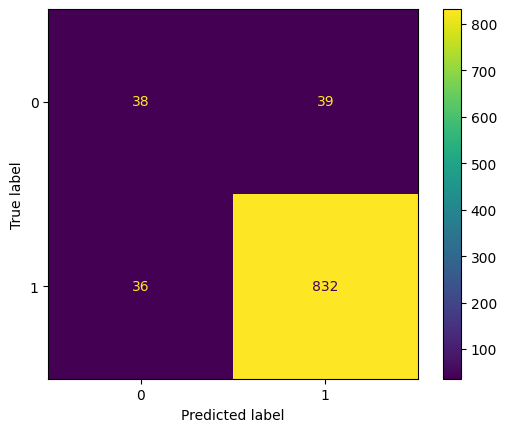

In [92]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_rf.classes_)
cm_display.plot()
plt.show()

In [102]:
import pickle

# -----------------------------
# Save Random Forest model
# -----------------------------
with open("best_rf.pkl", "wb") as f:
    pickle.dump(best_rf, f)
print("Random Forest model saved as best_rf.pkl")

# -----------------------------
# Save TF-IDF vectorizer
# -----------------------------
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")

# -----------------------------
# Save scaler (if used)
# -----------------------------
# If you used MinMaxScaler or any scaler
# with open("scaler.pkl", "wb") as f:
#     pickle.dump(scaler, f)
# print("Scaler saved as scaler.pkl")


Random Forest model saved as best_rf.pkl
TF-IDF vectorizer saved as tfidf_vectorizer.pkl


In [103]:
def preprocess_text(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in stopword]
    return ' '.join(review)

def predict_feedback(review, model, vectorizer, threshold=0.34):
    X = vectorizer.transform([preprocess_text(review)]).toarray()
    proba = model.predict_proba(X)[0]
    pred = 0 if proba[0] > threshold else 1
    return pred, proba
    
reviews = [
    "The product is terrible, very disappointed",
    "I love this! Excellent quality and fast delivery",
    "Not satisfied, it broke after one day",
    "Amazing product, works perfectly"
]

for r in reviews:
    pred, proba = predict_feedback(r, best_rf, tfidf)
    print(f"Review: {r}")
    print(f"Predicted Class: {pred}, Probabilities: {proba}")
    print("-"*60)


Review: The product is terrible, very disappointed
Predicted Class: 0, Probabilities: [0.40087041 0.59912959]
------------------------------------------------------------
Review: I love this! Excellent quality and fast delivery
Predicted Class: 1, Probabilities: [0.0651355 0.9348645]
------------------------------------------------------------
Review: Not satisfied, it broke after one day
Predicted Class: 0, Probabilities: [0.36593762 0.63406238]
------------------------------------------------------------
Review: Amazing product, works perfectly
Predicted Class: 1, Probabilities: [0.082 0.918]
------------------------------------------------------------


In [105]:
import re
import pandas as pd
from nltk.stem import PorterStemmer

# -----------------------------
# Configuration
# -----------------------------
stemmer = PorterStemmer()
stopword = [...]  # same stopword list used in training
threshold_class0 = 0.34  # tuned threshold for negative class

# -----------------------------
# Functions
# -----------------------------
def preprocess_text(text):
    """Preprocess review: lowercase, remove stopwords, stem"""
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in stopword]
    return ' '.join(review)

def predict_feedback(review_text, model, vectorizer, threshold=0.34): # It is threshold for negative class
    """
    Predict feedback (0 = negative, 1 = positive) for a single review.
    Returns predicted class and probabilities.
    """
    # Preprocess
    processed_review = preprocess_text(review_text)
    
    # TF-IDF transform
    X = vectorizer.transform([processed_review]).toarray()
    
    # Predict probabilities
    y_proba = model.predict_proba(X)[0]  # [P(class 0), P(class 1)]
    
    # Apply threshold for class 0
    predicted_class = 0 if y_proba[0] > threshold else 1
    
    return predicted_class, y_proba

def predict_multiple_reviews(reviews, model, vectorizer, threshold=0.34):
    """
    Predict multiple reviews and return a DataFrame with results
    """
    results = []
    for r in reviews:
        pred_class, pred_prob = predict_feedback(r, model, vectorizer, threshold)
        results.append({
            "Review": r,
            "Predicted_Class": pred_class,
            "Prob_Class0": pred_prob[0],
            "Prob_Class1": pred_prob[1]
        })
    return pd.DataFrame(results)

# -----------------------------
# Example usage
# -----------------------------
test_reviews = [
    "The product is terrible, very disappointed",
    "I love this! Excellent quality and fast delivery",
    "Not satisfied, it broke after one day",
    "Amazing product, works perfectly"
]

df_results = predict_multiple_reviews(test_reviews, best_rf, tfidf)
df_results


,Review,Predicted_Class,Prob_Class0,Prob_Class1
0,"The product is terrible, very disappointed",0,0.400870,0.599130
1,I love this! Excellent quality and fast delivery,1,0.065135,0.934865
2,"Not satisfied, it broke after one day",0,0.365938,0.634062
3,"Amazing product, works perfectly",1,0.082000,0.918000


In [107]:
test_reviews = [
    # Negative reviews
    "The product is terrible, very disappointed",
    "It broke after one day of use, waste of money",
    "Customer service was awful, will not buy again",
    "I am extremely unhappy with this purchase",
    "Poor quality, does not work as advertised",
    "The item arrived late and damaged",
    "Not satisfied, very low quality",
    "Terrible experience, the product stopped working immediately",
    "Very disappointed, will never buy from this brand",
    "The product does not match the description",

    # Positive reviews
    "I love this! Excellent quality and fast delivery",
    "Amazing product, works perfectly",
    "Highly recommend, very satisfied with the purchase",
    "Five stars! Exactly as described and works great",
    "The product exceeded my expectations",
    "Fast shipping, great quality, very happy",
    "Fantastic experience, the product is perfect",
    "Very good, exactly what I needed",
    "Excellent quality, will buy again",
    "Totally worth the price, very happy with it"
]

result = predict_multiple_reviews(test_reviews, best_rf, tfidf)
result

,Review,Predicted_Class,Prob_Class0,Prob_Class1
0,"The product is terrible, very disappointed",0,0.400870,0.599130
1,"It broke after one day of use, waste of money",0,0.515864,0.484136
2,"Customer service was awful, will not buy again",0,0.502855,0.497145
3,I am extremely unhappy with this purchase,1,0.216377,0.783623
4,"Poor quality, does not work as advertised",0,0.417000,0.583000
5,The item arrived late and damaged,0,0.534709,0.465291
6,"Not satisfied, very low quality",0,0.433073,0.566927
7,"Terrible experience, the product stopped worki...",0,0.579000,0.421000
8,"Very disappointed, will never buy from this brand",0,0.370512,0.629488
9,The product does not match the description,1,0.146541,0.853459


In [108]:
test_reviews1 = [
    # Negative reviews
    "The product is terrible, very disappointed",
    "It broke after one day of use, waste of money",
    "Customer service was awful, will not buy again",
    "I am extremely unhappy with this purchase",
    "Poor quality, does not work as advertised",
    "The item arrived late and damaged",
    "Not satisfied, very low quality",
    "Terrible experience, the product stopped working immediately",
    "Very disappointed, will never buy from this brand",
    "The product does not match the description",
    "Completely useless, does not function at all",
    "Broke within hours, I regret buying it",
    "The packaging was damaged and product defective",
    "Not worth the price, very poor quality",
    "I received the wrong item, very frustrating",
    "Worst purchase ever, extremely dissatisfied",
    "The product is fake and low quality",
    "Delivery was delayed and product damaged",
    "It stopped working after a week",
    "The features advertised are missing",

    # Positive reviews
    "I love this! Excellent quality and fast delivery",
    "Amazing product, works perfectly",
    "Highly recommend, very satisfied with the purchase",
    "Five stars! Exactly as described and works great",
    "The product exceeded my expectations",
    "Fast shipping, great quality, very happy",
    "Fantastic experience, the product is perfect",
    "Very good, exactly what I needed",
    "Excellent quality, will buy again",
    "Totally worth the price, very happy with it",
    "The product is durable and works flawlessly",
    "Superb quality, extremely satisfied",
    "Perfect fit and works as promised",
    "Outstanding product, highly recommend",
    "Very pleased with the purchase",
    "Product arrived quickly and works great",
    "High-quality item, excellent customer experience",
    "Absolutely love it, works exactly as expected",
    "Reliable product, I am very happy",
    "Exceptional quality, five-star product",
    "Love the design and functionality",
    "Very happy, product works perfectly",
    "Excellent service and product quality",
    "Good value for money, highly recommend",
    "Exceeded my expectations, very satisfied",
    "Amazing experience, product works great",
    "Product is sturdy and long-lasting",
    "Happy with the purchase, highly recommend",
    "Top-notch quality, would buy again",
    "Fantastic product, very reliable",
    "Product works well, excellent purchase",
    "Thrilled with the product, highly recommend",
    "Great quality and fast delivery",
    "Very satisfied, product meets expectations",
    "Reliable and efficient, works perfectly",
    "Happy customer, will buy again",
    "Exactly what I wanted, highly satisfied",
    "Product performs excellently, great quality",
    "I am impressed, works flawlessly",
    "Excellent product, very happy with purchase",
    "Perfect product, exactly as advertised",
    "Very pleased, quality is excellent",
    "Highly recommend this product, works great",
    "Product is worth every penny",
    "Fantastic quality and performance",
    "Product exceeded my expectations, very happy",
    "Great design and functionality, highly recommend",
    "Top quality, very satisfied",
    "Absolutely perfect, would buy again",
    "Extremely happy with this purchase"
]


In [110]:
test_review_df = predict_multiple_reviews(test_reviews1, best_rf, tfidf)
test_review_df.head(50)

,Review,Predicted_Class,Prob_Class0,Prob_Class1
0,"The product is terrible, very disappointed",0,0.400870,0.599130
1,"It broke after one day of use, waste of money",0,0.515864,0.484136
2,"Customer service was awful, will not buy again",0,0.502855,0.497145
3,I am extremely unhappy with this purchase,1,0.216377,0.783623
4,"Poor quality, does not work as advertised",0,0.417000,0.583000
5,The item arrived late and damaged,0,0.534709,0.465291
6,"Not satisfied, very low quality",0,0.433073,0.566927
7,"Terrible experience, the product stopped worki...",0,0.579000,0.421000
8,"Very disappointed, will never buy from this brand",0,0.370512,0.629488
9,The product does not match the description,1,0.146541,0.853459


In [86]:
# Evaluate the f1 score at different threshold 
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for thr in thresholds:
    y_pred_thr = (y_proba > thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr, pos_label=0)  # focus on class 0
    f1_scores.append(f1)

In [88]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Max F1 for class 0: {best_f1:.4f}")

Best Threshold: 1.00
Max F1 for class 0: 0.1507


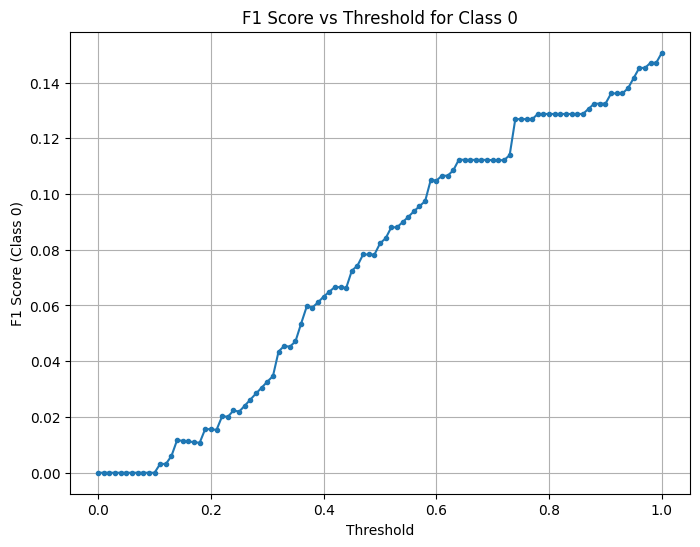

In [89]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores, marker='.')
plt.xlabel('Threshold')
plt.ylabel('F1 Score (Class 0)')
plt.title('F1 Score vs Threshold for Class 0')
plt.grid(True)
plt.show()

#### Apply GridSearchCV

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res)

print("Grid Search CV : Best Parameters:", grid_search.best_params_)


KeyboardInterrupt: 